In [282]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys             
from sympy import *                                # Module to see files and folders in directories
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit
import pandas as pd
import os
from importlib import reload

sys.path.append('../External_Functions')
import ExternalFunctions
reload(ExternalFunctions)
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

sys.path.append('../Extra_External_Functions')
import EEF
reload(EEF)
from EEF import Datahandler

In [294]:
# Usefull functions
def acceptreject(func, xmin, xmax, ymin, ymax, N_points):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran)
    xkeep = xran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing)
    else:
        xrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaltries = N_points + tries
    return finalx, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points):
    x, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, tries, area, eff

def F_dis(dataset1, dataset2):
    var1 = np.var(dataset1, ddof = 1)
    var2 = np.var(dataset2, ddof = 1)
    if var1 > var2:
        F = var1/var2
    else:
        F = var2/var1
    print(F)
    return F

def student_t(dataset1, dataset2):
    mean1 = np.mean(dataset1)
    var1 = np.var(dataset1, ddof = 1) #Estimated var
    N1 = len(dataset1)
    mean2 = np.mean(dataset2)
    var2 = np.var(dataset2, ddof = 1) #Estimated var
    N2 = len(dataset2)
    S = np.sqrt(((N1-1)*var1 + (N2-1)*var2)/(N1+N2-2))
    t = (mean1 - mean2)/(S * np.sqrt(1/N1 + 1/N2))
    print(t)
    return t

def geterrors(z, symlist, vals, sigmas):    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz

def geterrors_corr(z, symlist, vals, sigmas, corrmatrix):    
    def variances(func, symbols, values, sigmas, corrmatrix):
        # Makes a variance matrix which can we summed and sqrt'ed to find the uncertainty
        # ***Need to be rework to it make more general for more correlations*** 
        # ***Would also be nice to not have a nested loop***
        variance = np.zeros((len(symbols), len(symbols)))
        for idx, (isymbol, isigma) in enumerate(zip(symbols,sigmas)):
            for jdx, (jsymbol, jsigma) in enumerate(zip(symbols,sigmas)):
                
                f = lambdify(symbols, func.diff(isymbol) * func.diff(jsymbol) * isigma * jsigma * corrmatrix[idx, jdx])
                variance[idx, jdx] = f(*values)
        
        return variance
    Vz = variances(z, symlist, vals, sigmas, corrmatrix)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz.flatten()))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz 

def basicinfo(data):
    entries = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof = 1)
    eom = std/np.sqrt(entries)
    print(f"Data has {entries:d} entries with the mean = {mean:.3f} +/- {eom:.3f} and std = {std:.3f}")
    return entries, mean, std, eom

def chi2test_onesample(expY, y, sy):
    return np.sum((y - expY)**2/sy**2)

def gensum(pdf, xmin, xmax, ymin, ymax, rn, runs):
    results = np.zeros(runs)
    for i in range(runs):
        xvalues, _ = acceptreject(pdf, xmin, xmax, ymin, ymax, rn)
        results[i] = np.sum(xvalues)
    return results



## Problem 1
#### (1.1)

In [12]:
# Little Peter goes to the casino and puts money on black (p = 18/37)

# Part 1. In 50 games, what are the chances that he will win exactly 25 times? 26 times or more?
# First note that this is not an american casino.
# Then this problem can be solved using the binomial distribution and survival function.
p = 18/37
N = 50
r = 25
prob25 = stats.binom.pmf(r, N, p)
print(prob25) # 0.11
prob26a = stats.binom.sf(r, N, p)
print(prob26a) # 0.37
# Part 2. How many times does he have to play in order to be 95% sure of winning at least 20 times
 
for i in range(50, 200):
    prob20a = stats.binom.sf(19, i, p)
    if prob20a >= 0.95:
        print(i, prob20a)
        break
# After playing 53 times he ends up with a probability, of winning 20 or more times, of 0.96

0.11024273088617192
0.36945811661547345
53 0.9586214203699808


#### (1.2)

In [20]:
# What is the probability of a Gaussian value to lie between 1.2σ and 2.5σ away from the mean?

# I interpret this as 1.2 sigma to 2.5 sigma in both directions. 

# def unit gaussian.
sigma = 1
mu = 0

# One sided probability
prob12_25sigma = stats.norm.cdf(- 1.2, mu, sigma) - stats.norm.cdf(-2.5, mu, sigma)
print(prob12_25sigma) # p = 0.11

# Two sided:
print(2 * prob12_25sigma) # p = 0.22

# test
pcenter = stats.norm.cdf(1.2, mu, sigma) - stats.norm.cdf(- 1.2, mu, sigma)
print(pcenter + 2 * prob12_25sigma + 0.01242) # this gives 1 so the calculation is correct

0.10886000489593209
0.21772000979186418
1.0000006693484478


#### (1.3)

4.88 0.060541388655154606 0.06027397260273973
4.879995176024899


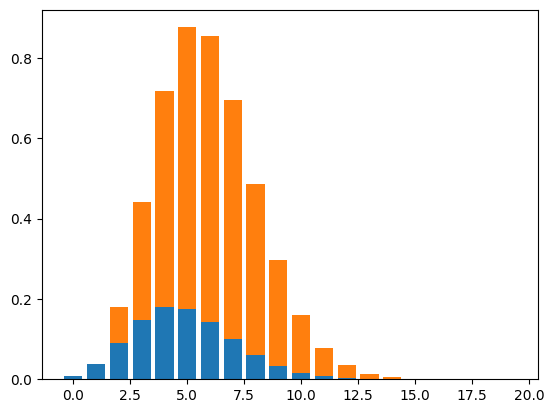

In [54]:
# The number of serious mistakes committed during operations on patients at 
# Danish hospitals are counted daily.

# Part 1. This would follow a poisson distribution, as it is discrete events which does not have a definite probability of occuring

# Part 2. 
for i in np.linspace(0, 100, 10001):
    if stats.poisson.sf(8, i) > 22/365:
        print(i, stats.poisson.sf(8, i), 22/365)
        lamb = i
        break

x = np.arange(0,20)
y = [stats.poisson.pmf(i, lamb) for i in x]
plt.bar(x,y)
y = [stats.poisson.pmf(i, lamb)*i for i in x]
plt.bar(x,y, zorder = -1)
exp = np.sum([stats.poisson.pmf(i, lamb)*i for i in x]) # This is stupid. lambda is ofcourse my expectation value
print(exp) # my estimate is 5 daily mistakes

## Problem 2
#### (2.1)

In [96]:
# A measurement of a tumor depth (in cm) was done using two methods. 
# The first gave 4 measurements with uncertainty while the second gave 12 without, as shown in the table

# Part 1. Do the measurements with uncertainty agree with each other? Do those without?
# Assuming noted errors are gaussian, we can calculate p values for each pair of measurement
values4 = [2.05, 2.61, 2.46, 2.48]
errors4 = [0.11, 0.10, 0.13, 0.12]
values12 = [2.69, 2.71, 2.56, 2.48, 2.34, 2.79, 2.54, 2.68, 2.69, 2.58, 2.66, 2.70]

# for the values with known uncertainty we can just ask if the two gaussians the measurements represent are the same
# We have 6 pairs
# I give them a 5% significance interval
def twosampleknownsigma(mean1, sigma1, mean2, sigma2):
    dif = np.abs(mean1 - mean2)
    sigma = np.sqrt(sigma1**2 + sigma2**2) # assuming no correlation
    sigmasfrom0 = dif/sigma
    # two tailed
    print(sigmasfrom0)
    return 2 * stats.norm.cdf(-sigmasfrom0, 0, 1)
pvalues4 = []
for idx, (mean1, sigma1) in enumerate(zip(values4, errors4)):
    for jdx, (mean2, sigma2) in enumerate(zip(values4, errors4)):
        if jdx > idx:
            print(mean1, mean2)
            p = twosampleknownsigma(mean1, sigma1, mean2, sigma2)
            pvalues4.append(p)
print(pvalues4)
# I get the p value list of: [0.00016524240548922056, 0.016057636314408277, 0.008254736045617104, 0.36041944049793073, 0.4052736482772131, 0.9099935440917983]
# Here it seems like 1 is not compatible with any of the measurements. 
# While the rest is in agreement within the set significance level
print(stats.binom.sf(0, 6, pvalues4[0])) # p = 0.001
# Given the 6 parings there is only a 0.001 probability of getting a result 3.77 sigma from the expected difference of 0
# Therefore we most conclude that the measurements are not in agreement with eachother

_, mean12, std12, eom12 = basicinfo(values12)
chi2 = chi2test_onesample(mean12, values12, std12)
print(stats.anderson(values12))
# I assume that the data should be gaussianæy distributed about some true mean with an true uncertainty.
# This distributing is unknown, but the best we can do is use the anderson darling test to test for normality in the data
# The criteria i set is a 5% significance and the null hyp is that the data is normal
# From the test i gen an A**2 value of 0.5 which is lower than the critical value of 0.679. 
# Therefore, a accept that they agree with eachother. 
# 
# Part 2. Which of the two methods provide the most precise positioning?
# The measure of precision is how well the values agree with each other.
# For the measurements without uncertainty this is just the error on the mean.
print(eom12) # eom = 0.04

# If i naively does the calculation of the weighted eom for the measurements with uncertainty is get
def weightedeom(errors):
    errors = np.array(errors)
    return np.sqrt(1/np.sum(1/errors**2))
weom4 = weightedeom(errors4)
print(weom4) # eom = 0.06
# Even with all 4 points taken into the calculation the presision is still lower than for the 12 points

# Part 3. What is your best estimate of the tumors position? And with what uncertainty?
# I have established that the 12 measurements are in better agreement with eachother and ends up having h higher presision therefore, this is the best estimator of the tumor size.
# the size was calculated to be 2.62 +/- 0.4



2.05 2.61
3.76696764637935
2.05 2.46
2.407602900010285
2.05 2.48
2.6414690023859912
2.61 2.46
0.9145661412745381
2.61 2.48
0.832239719563823
2.46 2.48
0.11304668378884439
[0.00016524240548922056, 0.016057636314408277, 0.008254736045617104, 0.36041944049793073, 0.4052736482772131, 0.9099935440917983]
0.0009910449473746143
Data has 12 entries with the mean = 2.618 +/- 0.036 and std = 0.124
AndersonResult(statistic=0.5031511889298699, critical_values=array([0.497, 0.566, 0.679, 0.792, 0.942]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
0.0356717640084528
0.05668104857370456


#### (2.2)

In [115]:
from sympy import exp
# Part 1. Given values of ν = (0.566 ±0.025) ×1015 Hz and T = (5.50 ±0.29) ×103 K (uncorrelated), what is the expected spectral radiance, B?

nu, T = symbols("nu T")
values = [0.566 * 10**15, 5.50 * 10**3]
errors = [0.025 * 10**15, 0.29 * 10**3]
h = 6.626 * 10**(-34)
c = 2.997 * 10**6
kb = 1.381 * 10**(-23)
blackbody = 2*h*nu**3 / c**2 * 1/(exp(h * nu / (kb * T)) - 1)
hmm = exp(nu)
B, Berror = geterrors(blackbody, [nu, T], values, errors)
print(B, Berror)

# Part 2. How does the uncertainty change, if there is a correlation of ρ(ν,T) = 0.87?

corrmatrix = np.array([
    [1, 0.87], 
    [0.87, 1]
    ])
B_corr, Berror_corr = geterrors_corr(blackbody, [nu, T], values, errors, corrmatrix)
print(B_corr, Berror_corr)
# The corralation decreases the uncertainty

Hmm
[2.83702245e-10 2.56809420e-09]
0.00019325583836148652 5.3402213836962665e-05
[[ 2.83702245e-10 -7.42601998e-10]
 [-7.42601998e-10  2.56809420e-09]]
0.00019325583836148652 3.696745116709461e-05


## Problem 3
#### (3.1)

0.6628368775348104
1.1744892484745697
1.280628959562784


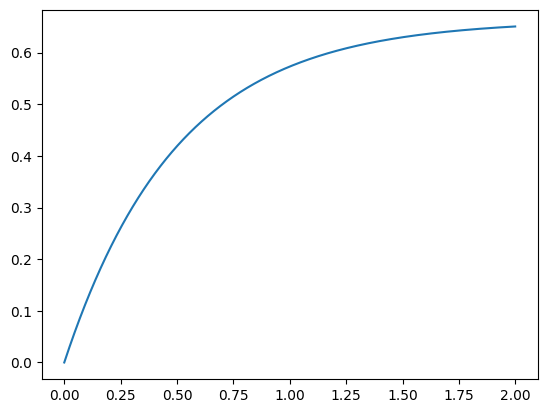

0.7739938080495357 1.0072702734423322
1.1875027340730013
1.2956733618097773
True
[319.6593077   1.9421651] [28.23139725  0.47249156]
[342.53145851   1.83770957] [29.8567424   0.42227812]


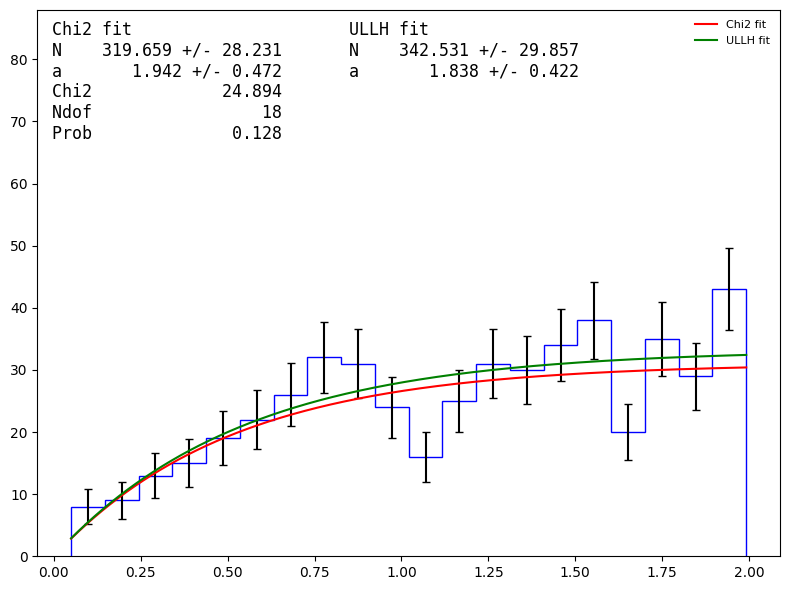

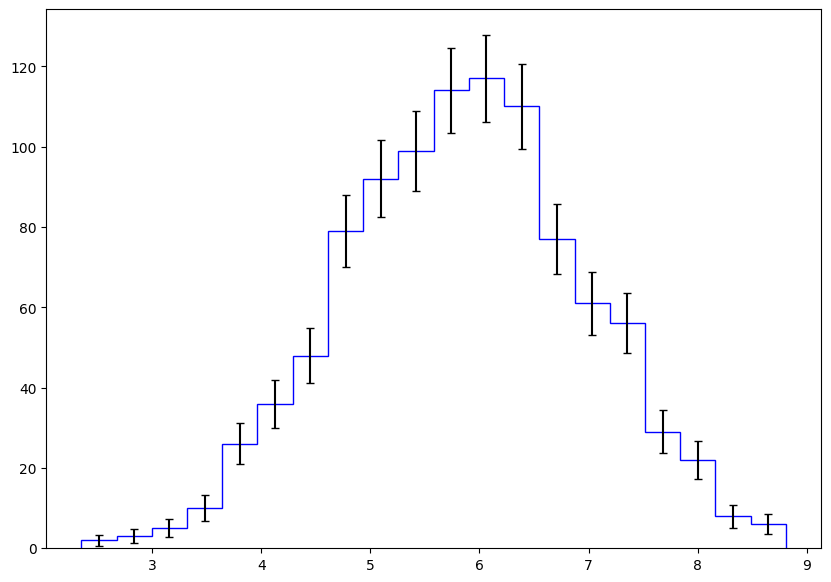

AndersonResult(statistic=0.23498997695799062, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [298]:
# See problem description
# Part 1. What is the mean and RMS of f(x)? Also, what is the value of C?
def fx_unnorm(x):
    return 1 - np.exp(-2*x)

# do numerical integration
step = 0.001
xmin = 0
xmax = 2
xlin = np.arange(xmin, xmax, step)
area = np.sum(fx_unnorm(xlin) * step)
C = 1/area
print(C) # C = 0.662
def fx(x):
    return C * (1 - np.exp(-2*x))
mean = np.sum(xlin * fx(xlin)) * step
print(mean) # mean = 1.18
RMS = np.sqrt(np.sum(xlin**2 * fx(xlin)) * step)
print(RMS) # RMS = 1.28
plt.plot(xlin, fx(xlin))
plt.show()
# Part 2. What method(s) can be used to produce random numbers according to f(x)? Why?
# I will use accept/reject.
# It is effecient as I do not need to do any integration or invers calculation. 
# The PDF got a low variation in y and the method should be effective

# Part 3. Produce 500 random numbers distributed according to f(x) and plot these
ymax = fx(2)
ymin = fx(0)
N_points = 500
xvalues, tries, checkarea, checkeff = acceptrejectdata(fx, xmin, xmax, ymin, ymax, N_points) 
print(checkeff, checkarea)

# check calculated values
print(np.mean(xvalues))
print(np.sqrt(np.mean(xvalues**2)))
# And they are in agreement

# Part 4. 
bins = 20
mc = Datahandler(xvalues, bins)
print(mc.binned)
mc.initplot(figsize = (8,6))
mc.quickplot()
def fit_fx_bin(x, N, a):
    return N * mc.binwidth * (1 - np.exp(-a*x))
values, errors = mc.chi2fit(fit_fx_bin, N=300, a = 2)
print(values, errors)
mc.plotfit(extra_spacing=-3)
def fit_fx(x, N, a):
    return N * (1 - np.exp(-a*x))
values, errors = mc.ullhfit(fit_fx, extended = True, N=300, a = 2.1)
print(values, errors)
mc.plotfit(textboxspace = 0.4, extra_spacing=-3)
mc.legend()
mc.savefig()
plt.show()
# Part 5. Let u be a sum of 5 random values from f(x). Produce 1000 values of u and test if they are consistent with a Gaussian distribution
u = gensum(fx, xmin, xmax, ymin, ymax, 5, 1000)
ud = Datahandler(u, 20)
ud.initplot()
ud.quickplot()
plt.show()
# setting the null hypothesis significance to 5% the distribution easily passes
print(stats.anderson(u))